In [1]:
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd
from pandas import Series
from pmdarima.arima import auto_arima
import numpy as np
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
from sklearn.linear_model import LinearRegression
pd.set_option('display.max_Rows', 13000)
pd.set_option('display.max_columns', 12000)
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
from termcolor import colored
from math import pi
from pandas.plotting import autocorrelation_plot
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA
from math import sqrt
from xgboost import XGBRegressor

In [2]:
df_xlsx = pd.read_excel('Bucket Performance_thesis.xlsx')
df = df_xlsx.copy()

In [3]:
poland = df.loc[df.CLIENT == "MONEDONOW_PL"]
pl_byaccount= poland.groupby(['EOM_BUCKET_GROUPED','REPORTING_MONTH'])['NR_ACCOUNTS'].sum().reset_index()
pl_byaccount.head()
pl_byAccount = pd.pivot_table(poland, values= ["NR_ACCOUNTS"], index= ["EOM_BUCKET_GROUPED"], columns= ["REPORTING_MONTH"],margins=False , fill_value= 0,aggfunc="sum")
pl_byAccount_x = pl_byAccount.copy()
pl_byAccount_x.columns = [''.join(col).strip() for col in pl_byAccount_x.columns.values]
poland_complete = pl_byAccount_x.T
poland_cleaned = poland_complete.reset_index()
poland_cleaned.rename(columns={'index':'Date_time'},inplace=True)
poland_cleaned['Date_time'] = poland_cleaned['Date_time'].map(lambda x: str(x)[11:])
poland_final = poland_cleaned.drop(['210+','Closed','Extra','NPL Sales','180-209', 'Court', '1-29', '120-149','150-179','30-59','90-119','60-89'], axis=1)
poland_final.tail()

EOM_BUCKET_GROUPED,Date_time,Performing
46,2020-04,18920
47,2020-05,19214
48,2020-06,19313
49,2020-07,19019
50,2020-08,19127


In [4]:
poland_final.describe()

EOM_BUCKET_GROUPED,Performing
count,51.000000
mean,11934.411765
std,5063.459707
min,2212.000000
25%,7247.000000
50%,13221.000000
75%,14927.000000
max,19313.000000


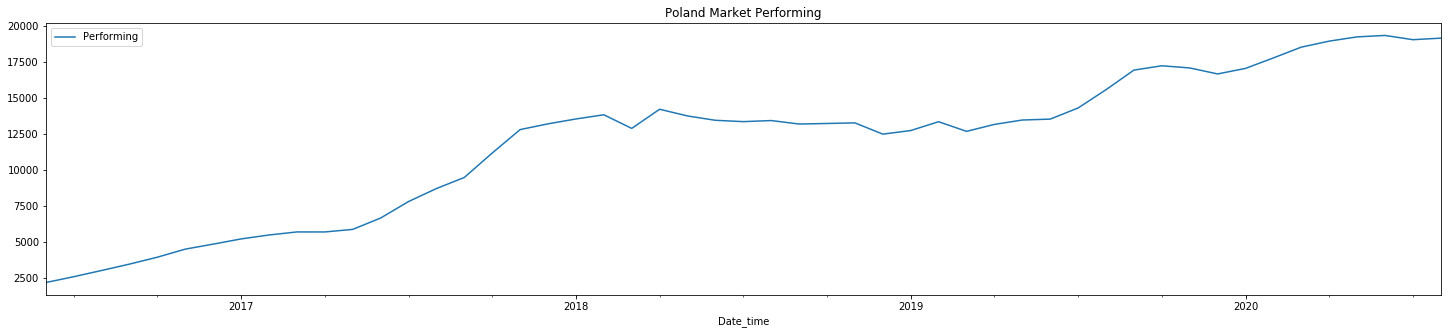

In [5]:
poland_final.Date_time = pd.to_datetime(poland_final.Date_time, dayfirst = True )
poland_final.set_index('Date_time', drop = True ,inplace = True)
poland_final['Performing'].plot(figsize = (25,5), label = "Performing")

plt.title('Poland Market Performing')

plt.legend(loc = 'best')
plt.show()

In [6]:
# Create a superviced Model
poland_final["target"] = poland_final['Performing'].shift(-1)
poland_final.dropna(inplace=True)

In [7]:
poland_final.tail()

EOM_BUCKET_GROUPED,Performing,target
Date_time,,
2020-03-01,18504,18920.0
2020-04-01,18920,19214.0
2020-05-01,19214,19313.0
2020-06-01,19313,19019.0
2020-07-01,19019,19127.0


# split data into X and y
size= int(len(poland_final)*0.9)
preforming_training = poland_final["target"].iloc[:size]
performing_Test = poland_final["target"].iloc[size:]
performing_Test

data = poland_final.values
n = int(len(data) * (1 - perc))

In [8]:
def train_test_split(data):
    data = data.values
    n = int(len(data)- (len(data)*0.1))
    #print(n)
    return data[:n], data[n:]

In [9]:
train, test = train_test_split(poland_final)


In [10]:
print(len(poland_final))
print(len(train))
print(len(test))

50
45
5


In [11]:
print(test)

[[18504. 18920.]
 [18920. 19214.]
 [19214. 19313.]
 [19313. 19019.]
 [19019. 19127.]]


In [12]:
#reg:squarederror
#count:poisson

In [13]:
from xgboost import plot_tree
def xgb_predict(train, val):
    train = np.array(train)
    X, y = train[:, :-1], train[:, -1]
    model = XGBRegressor(max_depth=1, objective="count:poisson", n_estimators=1000, reg_lambda=1)
    model.fit(X, y)
    #print(model)
    #plot_tree(model)
    #plt.show()
    val = np.array(val).reshape(1, -1)
    pred = model.predict(val)
   
    

    return pred[0]

In [14]:
xgb_predict(train, test[0, 0])

18441.17

In [15]:
def validate(data, perc):
    predictions = []

    train, test = train_test_split(data)

    history = [x for x in train]

    for i in range(len(test)):
        test_X, test_y = test[i, :-1], test[i, -1]

        pred = xgb_predict(history, test_X)
        predictions.append(pred)

        history.append(test[i])
        print('>expected=%.1f, predicted=%.1f' % (test_y, pred))

    error = mean_squared_error(test[:, -1], predictions, squared=False)
    error_1= mean_absolute_error(test[:, -1], predictions)
    rmspe = (np.sqrt(np.mean(np.square((test_y - predictions) / test_y)))) * 100
        
    return error, test[:, -1], predictions,error_1,rmspe

In [16]:
rmse, y, pred,mae,rmspe = validate(poland_final, 10)
print('rmse: %.3f' % rmse)
print('mae: %.3f' % mae)
print('rmspe: %.3f' % rmspe)

>expected=18920.0, predicted=18441.2
>expected=19214.0, predicted=18859.2
>expected=19313.0, predicted=19144.8
>expected=19019.0, predicted=19247.7
>expected=19127.0, predicted=19171.4
rmse: 295.879
mae: 254.982
rmspe: 1.748


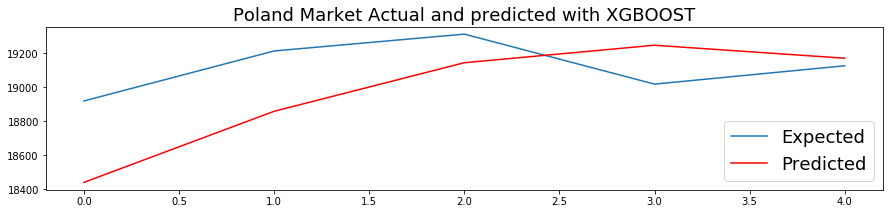

In [19]:
# plot expected vs preducted
plt.figure(figsize=(15,3))
plt.plot(y, label='Expected')
plt.plot(pred, label='Predicted',color='red')
plt.title('Poland Market Actual and predicted with XGBOOST',fontsize = 18)
plt.legend(fontsize = 18)
plt.show()